## A/B test in online store


**Task**: analyse results of A/B test launched by previous data analyst in online store. We have: test results, technical task, some datasets.

### Contents
- [Technical task](#tt)
- [Datasets description](#data)
- [Plan of work](#plan)
- [Libraries](#libraries)
- [Data preparation](#prepare)
- [Data analysis](#analysis)
- [A/B test validation](#valid)
- [A/B test results](#abtestres)
- [Summary and recommendations](#result)

### Technical task from previous analyst <a id=tt> <a>

- Test name: `recommender_system_test`;
- Groups: А — control group, B — new funnel;
- Start date: 2020-12-07;
- End date for adding new clients to test: 2020-12-21;
- End date of test: 2021-01-04;
- Clients involved: 15% of new customers from region EU;
- Test goal: test changes made by new recommendation system;
- Expected amount of clients in test: 6 000.
- Expected result: all client metrics over 14 days from registration  will improve by at least 10%:
    - conversion into views — event `product_page`,
    - basket views — `product_cart`,
    - purchase — `purchase`.

### Datasets <a id=data> <a>

`ab_project_marketing_events.csv` — calendar of marketing campaigns in 2020.

File structure:

- `name` — marketing campaign name;
- `regions` — regions where this campaign was launched;
- `start_dt` — start date;
- `finish_dt` — end date.
-----------
    
`final_ab_new_users.csv` — clients who registered between 7th and 21st of December 2020.

File structure:

- `user_id` — client ID;
- `first_date` — registration date;
- `region` — client's region;
- `device` — device from whitch client registered.
-----------
    
`final_ab_events.csv` — new clients' actions during 7th December 2020 - 4th January 2021.

File structure:

- `user_id` — client ID;
- `event_dt` — date and time of action;
- `event_name` — type of action;
- `details` — additional data about action. For example for purchase it is price in dollars.
-----------
    
`final_ab_participants.csv` — test groups.

Структура файла:

- `user_id` — client ID;
- `ab_test` — test name;
- `group` — client's group.


### Plan<a id=plan> <a>

- Import data and prepare (check and correct data types, duplicates and empty cells).
- Analyse data:
    - How does conversion rate change through the funnel?
    - Does amount of actions per client differ in groups?
    - Are there clients with more than 1 group?
    - How do actions distributed over days?
    - What data features should we consider before A/B testing?
- Analyse test accuracy (duration, test audience, interference with other tests)
- Check A/B test results. 
- Summarize results and recomendations.

### Libraries <a id=libraries> <a>

In [2]:
import pandas as pd
from datetime import datetime as dt
from plotly import graph_objects as go
import math
from scipy import stats as st
import matplotlib.pyplot as plt

### Data preparation <a id=prepare> <a>
#### Import, check duplicates, check data types.
_Table ab_project_marketing_events_

In [4]:
calendar = pd.read_csv('ab_project_marketing_events.csv')
calendar

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


_Table final_ab_events_

In [5]:
final_ab_events = pd.read_csv('final_ab_events.csv')
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [6]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [7]:
#Correct data type for date-time field event_dt
final_ab_events['event_dt'] = final_ab_events['event_dt'].map(lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [8]:
#Look for duplicates
final_ab_events[final_ab_events.duplicated()]

,user_id,event_dt,event_name,details


In [9]:
#What actions do we have?
final_ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

_Table final_ab_new_users_

In [10]:
final_ab_new_users = pd.read_csv('final_ab_new_users.csv')
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [11]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [12]:
#Correct data type for date field
final_ab_new_users['first_date'] = final_ab_new_users['first_date'].map(lambda x: dt.strptime(x, '%Y-%m-%d'))

In [13]:
#What regions do we have?
final_ab_new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [14]:
#What devices do we have?
final_ab_new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [15]:
#Check if every client have only one set of parameters
final_ab_new_users[final_ab_new_users['user_id'].duplicated()]

,user_id,first_date,region,device


_Table final_ab_participants_

In [19]:
final_ab_participants = pd.read_csv('final_ab_participants.csv')
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [20]:
#What tests do we have?
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

#### First analyse, data cleaning, table merging

In [21]:
calendar[(calendar['start_dt']<'2021-01-05') & (calendar['finish_dt']>'2020-12-07')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


We see that our test in EU intersects Christmas&New Year Promo. If this Promo effects our test then dates for our test were chosen wrong from the beginning and all its results are not right. During Christmas holidays people tend to buy everything and new interface can't stop them so it's most likely that this Promo broke our A/B test and its results.
But in scope of this work we'll still look at its results.

Table final_ab_new_users - in accordance with technical task we'll take only region EU and registration dates 07.12.2020 - 21.12.2020 incl.

In [22]:
eu_ab_new_users = final_ab_new_users[final_ab_new_users['region']=='EU']

In [23]:
print('Minimal registration date:', eu_ab_new_users['first_date'].min(),
     '\nMaximal registration date :', eu_ab_new_users['first_date'].max())

Minimal registration date: 2020-12-07 00:00:00 
Maximal registration date : 2020-12-23 00:00:00


In [24]:
eu_ab_new_users = final_ab_new_users[final_ab_new_users['first_date']<'2020-12-22']

Table final_ab_events - we'll check what dates we have in table with actions:

In [25]:
print('Minimal action date:', final_ab_events['event_dt'].min(),
     '\nMaximal action date:', final_ab_events['event_dt'].max())

Minimal action date: 2020-12-07 00:00:33 
Maximal action date: 2020-12-30 23:36:33


There's no data for the last 5 days of testing, though the test was planned to perform until 04.01.2021

Table recommender_ab_participants - clients' participation in two tests. We'll check if there are test intersections and choose those clients who participated only in our test.

In [26]:
recommender_ab_participants = final_ab_participants[
    (final_ab_participants['user_id'].isin 
             (final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']['user_id'])
    ) &
    ~(final_ab_participants['user_id'].isin
             (final_ab_participants[final_ab_participants['ab_test']=='interface_eu_test']['user_id'])
    )]
      
print('Amount of clients in our test: ',final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']['user_id'].count())
print('Amount of clients in our test who don\'t participate in other tests:',recommender_ab_participants['user_id'].count())

Amount of clients in our test:  6701
Amount of clients in our test who don't participate in other tests: 5099


We'll check if there's nobody who is simultaneously in two groups of testing.

In [27]:
countgroups = final_ab_participants.join(final_ab_participants.groupby(['user_id','ab_test'])['group'].count(), 
                                         rsuffix='_count', on = ['user_id','ab_test'])
countgroups['group_count'].unique()

array([1])

So each client is only in one group in each test.

We'll merge tables next. We'll take only clients from EU region, registered on 7th-21st of December who participated in our test recommender_system_test.

In [28]:
final_ab_events_eu = final_ab_events.merge(eu_ab_new_users, how='inner', on='user_id').\
                                     merge(final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test'], 
                                           how='inner', on='user_id')
final_ab_events_eu

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
...,...,...,...,...,...,...,...,...,...
24693,1E6B9298415AA97A,2020-12-22 03:22:34,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
24694,1E6B9298415AA97A,2020-12-23 11:34:53,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
24695,1E6B9298415AA97A,2020-12-24 18:45:58,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
24696,1E6B9298415AA97A,2020-12-25 16:40:01,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test


Next we'll delete clients who participate in other tests:

In [29]:
final_ab_events_eu_recom = final_ab_events.merge(eu_ab_new_users, how='inner', on='user_id').\
                                     merge(recommender_ab_participants[recommender_ab_participants['ab_test']=='recommender_system_test'], 
                                           how='inner', on='user_id')
final_ab_events_eu_recom

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,EU,Android,A,recommender_system_test
...,...,...,...,...,...,...,...,...,...
18799,1E6B9298415AA97A,2020-12-22 03:22:34,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
18800,1E6B9298415AA97A,2020-12-23 11:34:53,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
18801,1E6B9298415AA97A,2020-12-24 18:45:58,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test
18802,1E6B9298415AA97A,2020-12-25 16:40:01,login,NaN,2020-12-21,N.America,Android,B,recommender_system_test


### Data analysis <a id=analysis> <a>


_Distribution of action amount per client in groups_

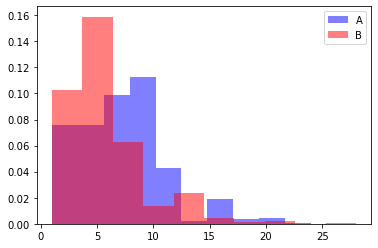

In [30]:
hist_data = final_ab_events_eu.groupby(['user_id','group'])['event_name'].count().reset_index()
plt.hist(data=hist_data[hist_data['group']=='A'], x='event_name', label='A', alpha=0.5, stacked=False, density=True, color='blue')
plt.hist(data=hist_data[hist_data['group']=='B'], x='event_name', label='B', alpha=0.5, stacked=False, density=True, color='red')
plt.legend()
plt.show()

In [31]:
print('Distribution of actions\' amount per client')
print('\nGroup A:\n',hist_data[hist_data['group']=='A']['event_name'].describe())
print('\nGroup В:\n',hist_data[hist_data['group']=='B']['event_name'].describe())

Distribution of actions' amount per client

Group A:
 count    2747.000000
mean        7.027303
std         3.868983
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
Name: event_name, dtype: float64

Group В:
 count    928.000000
mean       5.812500
std        3.483878
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       28.000000
Name: event_name, dtype: float64


In group A action amount per client and median of action amount is higher than in group B. Probably in group B client don't go back, moves straight through the funnel.

_Distribution of action amount over dates_

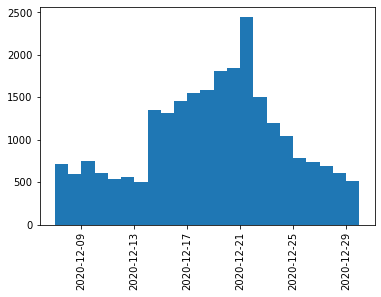

In [32]:
final_ab_events_eu['event_date'] = final_ab_events_eu['event_dt'].dt.floor('d')
day_length = (final_ab_events_eu['event_date'].max()-final_ab_events_eu['event_date'].min()).days
plt.hist(data=final_ab_events_eu, x='event_date', bins=day_length)
plt.xticks(rotation=90);

At the beginning of test we're still gathering clients for this test so we see less actions there. The highest amount of actions is on the 18th-22th of December.

_Groups sizes_

In [33]:
exp_count = final_ab_events_eu.groupby('group')['user_id'].nunique()
n_a = exp_count.loc['A']
n_b = exp_count.loc['B']
print('Amount of clients in each group: \n', exp_count)
print('\nGroup B size is {:.2%} of group A size'.format((n_b)/n_a ) )

Amount of clients in each group: 
 group
A    2747
B     928
Name: user_id, dtype: int64

Group B size is 33.78% of group A size


_Funnel in groups_

In [34]:
event_users_exp = final_ab_events_eu.pivot_table(index='event_name', columns='group', 
                                                values='user_id', aggfunc='nunique').\
                sort_values(by='A', ascending=False)
event_users_exp['total'] = event_users_exp['A'] + event_users_exp['B']
event_users_exp

group,A,B,total
event_name,,,
login,2747,928,3675
product_page,1780,523,2303
purchase,872,256,1128
product_cart,824,255,1079


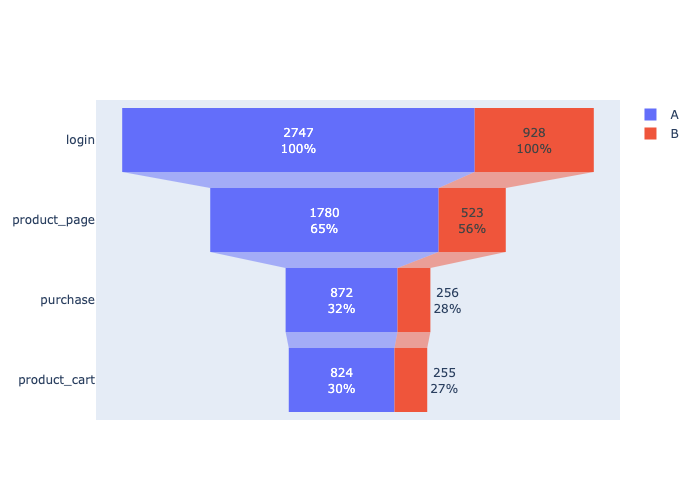

In [35]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = event_users_exp.index,
    x = event_users_exp['A'],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = 'B',
    y = event_users_exp.index,
    x = event_users_exp['B'],
    textinfo = "value+percent initial"))
fig.show(renderer='png');

Conversion rates in group B are the same or even worse than in control group A. We'll check later using z-test if there's statistically significant difference. 
It is remarkable that conversion into payment is higher than conversion into basket. That means that we have some type of "buy in one step" service without visiting basket.

Now we draw the same funnel for clients who participate only in our test:

group,A,B,total
event_name,,,
login,2082,706,2788
product_page,1360,397,1757
purchase,652,198,850
product_cart,631,195,826


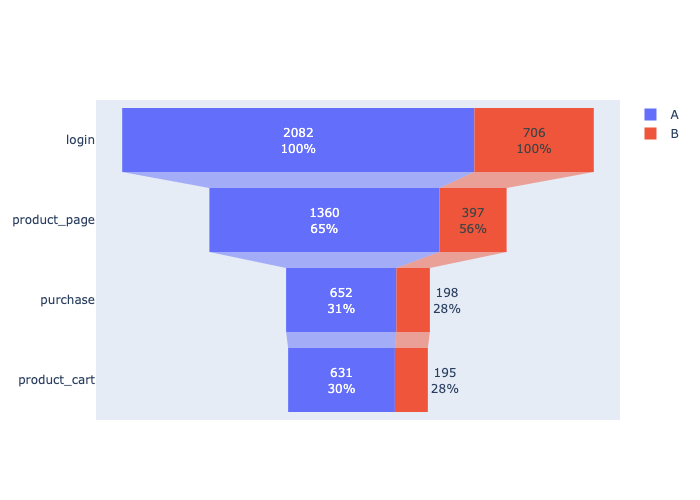

In [36]:
event_users_exp_recom = final_ab_events_eu_recom.pivot_table(index='event_name', columns='group', 
                                                values='user_id', aggfunc='nunique').\
                        sort_values(by='A', ascending=False)
event_users_exp_recom['total'] = event_users_exp_recom['A'] + event_users_exp_recom['B']
display(event_users_exp_recom)

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = event_users_exp_recom.index,
    x = event_users_exp_recom['A'],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = 'B',
    y = event_users_exp_recom.index,
    x = event_users_exp_recom['B'],
    textinfo = "value+percent initial"))
fig.show(renderer='png');

Conversion rates remain almost the same as on full dataset.

### A/B test validation <a id=valid> <a>
There are some issues in this test: 
    
    1. Intersection with Christmas Promo effects test results in unknown manner.
    2. Intersections with other tests - it is not a problem if our analysts checked in advance that they don't effect each other.
    3. Tere's no data from last 5 days of 14 test days. So we have clients younger than 14 days and can't properly check hypothesis for them.
    4. Groups are distributed unevenly.
    5. We expected around 6 000 clients in this test but there are only 3 675 clients with actions.
    6. We don't have information about A/A test so we don't know if clients were splited into groups correctly.

### A/B test results <a id=abtestres> <a>

In [37]:
# Hypothesis 0: there's no statistical difference of conversions in two groups
def compare_exp (data, alpha, exp_id1, exp_id2, event1, event2):
    # data - table with events
    # exp_id1 - name of control group
    # exp_id2 - name of test group
    # event1 and event2 - events which we calculate the conversion between
    
    
    
    #convertion from event1 to event2 in first group
    p1 = data.loc[event2][exp_id1] / data.loc[event1][exp_id1]
    
    #convertion from event1 to event2 in second group
    p2 = data.loc[event2][exp_id2] / data.loc[event1][exp_id2]
    
    #conversion into joint group
    p_combined = (data.loc[event2][exp_id1] + data.loc[event2][exp_id2])\
        / (data.loc[event1][exp_id1] + data.loc[event1][exp_id2])

    # difference in conversions
    difference = p1 - p2

    # z-value
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/data.loc[event1][exp_id1] + \
                                                                     1/data.loc[event1][exp_id2]))
    # N(0,1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("We reject zero hypothesis: there's statistically significant difference between groups in coversion to", event2, "\n")
    else:
        print("We fail to reject zero hypothesis, there's no evidence that conversion into", event2, "between groups is different\n")

In [38]:
alpha = 0.1

In [39]:
for indx in event_users_exp.drop('login').index :
    print('Action', indx)
    compare_exp(event_users_exp, alpha, 'A', 'B', 'login', indx)

Action product_page
p-value:  4.310980554755872e-06
We reject zero hypothesis: there's statistically significant difference between groups in coversion to product_page 

Action purchase
p-value:  0.017592402663314743
We reject zero hypothesis: there's statistically significant difference between groups in coversion to purchase 

Action product_cart
p-value:  0.14534814557238196
We fail to reject zero hypothesis, there's no evidence that conversion into product_cart between groups is different



### Summary and recomendations <a id=result> <a>

A/B test shows falling of conversion to Payment and to Product card in group B thus new funnel is not better.

But there were a lot of mistakes in test conducting that could effect test results (Christmas promo, lack of data on last dates, no A/A test). 

So we should stop this test and conduct it again according to all rules.